<a href="https://colab.research.google.com/github/huanhkv/Competition-HappyWhale2022/blob/main/competition_happywhale2022_tf_ecaresnet26t_GemPool_swa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%bash
unzip "/content/drive/MyDrive/Colab Notebooks/[Competition]HappyWhale2022/data/happywhale-splits.zip" -d happywhale-splits
cp "/content/drive/MyDrive/Colab Notebooks/[Competition]HappyWhale2022/data/sample_submission.csv" "sample_submission.csv"

Archive:  /content/drive/MyDrive/Colab Notebooks/[Competition]HappyWhale2022/data/happywhale-splits.zip


replace happywhale-splits/individual_ids.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [cp "/cont]
replace happywhale-splits/individual_ids.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ent/drive]
replace happywhale-splits/individual_ids.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [/MyDrive/]
replace happywhale-splits/individual_ids.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [Colab Not]
replace happywhale-splits/individual_ids.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ebooks/[C]
replace happywhale-splits/individual_ids.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ompetitio]
replace happywhale-splits/individual_ids.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace happywhale-splits/skf_species_10folds.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ale2022/d]
replace happywhale-splits/skf_species_10folds.csv? [y]es,

In [3]:
import os, re, json, glob, math, random, warnings

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import backend as K

warnings.filterwarnings('ignore')
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.8.0


In [4]:
!pip install tensorflow-addons
!pip install -q efficientnet
!pip install tfimm
!pip install timm==0.5.4

import tensorflow_addons as tfa
import tfimm
import efficientnet.tfkeras as efn

In [5]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    print('Not connected to a TPU runtime!')
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.59.203.74:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.59.203.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.203.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


# Parameters

In [6]:
class Parameters:
    # Device    
    device = 'tpu' if tpu is not None else 'cpu or gpu'
    num_device = REPLICAS
    
    # Path
    root = os.path.abspath('../') + 'content/'
        
    if tpu is not None:
        # from kaggle_datasets import KaggleDatasets
        # data_folderpath = KaggleDatasets().get_gcs_path('happywhale-tfrecords-bb') + '/' 
        data_folderpath = 'gs://kds-1a6a4ccf0eb63bdf264eecdeac8ba2c6391a8616af8c147a01a0a726/'
    else:
        data_folderpath = root + "input/happywhale-tfrecords-bb/"

    train_folderpath = data_folderpath + 'train_images/'
    test_folderpath = data_folderpath + 'test_images/'
    
    save_folderpath = root # + '/working/'
    
    # Seed
    seed = 42
    
    # Image
    image_size = (512, 512)
    
    # Model
    num_workers = 4 * num_device
    backbone = 'ecaresnet26t'
    margin = 0.5
    n_classes = 15587
    
   # ArcFace Hyperparameters
    s = 30
    m = 0.5
    ls_eps = 0.0
    easy_margin = False
    
    # Fold
    n_folds = 5
    run_fold = 1

    # Training
    train_batch_size = 32 * num_device
    valid_batch_size = 2 * train_batch_size
    lr = 1e-3
    lr_ramp_ep = 4
    epochs = 20
    early_stopping_patience = 7
    
    KNN = 100
    CUTOUT = False
    
    print(f"Using {device} device")
    print('Num device:', num_device)
    print('Num workers:', num_workers)
    print('Train batch size:', train_batch_size)
    print('Valid batch size:', valid_batch_size)
    print('Backbone:', backbone)
    print('n_folds:', n_folds)
    print('run_fold:', run_fold)
    
    resume = False
    resume_epoch = None
    
args = Parameters()

Using tpu device
Num device: 8
Num workers: 32
Train batch size: 256
Valid batch size: 512
Backbone: ecaresnet26t
n_folds: 5
run_fold: 1


# Utils

In [7]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)
    
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

True


## Dataset

In [8]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image, posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image, label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and args.CUTOUT:
        N_CUTOUT = 6
        for cutouts in range(N_CUTOUT):
            if tf.random.uniform([])>0.5:
                DIM = args.image_size[0]
                CUTOUT_LENGTH = DIM//8
                x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
                x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
                filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
                filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
                cutout = tf.reshape(1-filter_,(DIM,DIM,1))
                image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
# Updated to include crops.
def decode_image(image_data, box):
    if box is not None and box[0] != -1:
        left, top, right, bottom = box[0], box[1], box[2], box[3]
        bbs = tf.convert_to_tensor([top, left, bottom - top, right - left])
        image = tf.io.decode_and_crop_jpeg(image_data, bbs, channels=3)
    else:
        image = tf.image.decode_jpeg(image_data, channels = 3)

    image = tf.image.resize(image, args.image_size)
    # image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
        'detic_box': tf.io.FixedLenFeature([4], tf.int64),
         # 'yolov5_box': tf.io.FixedLenFeature([4], tf.int64),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    bb = tf.cast(example['detic_box'], tf.int32)
    image = decode_image(example['image'], bb)
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(args.train_batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(args.valid_batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(args.valid_batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(args.valid_batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

## Layers

In [9]:
class GeMPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, p=3., train_p=False):
        super().__init__()
        if train_p:
            self.p = tf.Variable(p, dtype=tf.float32)
        else:
            self.p = p
            self.eps = 1e-6

    def call(self, inputs: tf.Tensor, **kwargs):
        inputs = tf.clip_by_value(
            inputs, 
            clip_value_min=1e-6, 
            clip_value_max=tf.reduce_max(inputs)
        )
        inputs = tf.pow(inputs, self.p)
        inputs = tf.reduce_mean(inputs, axis=[1, 2], keepdims=False)
        inputs = tf.pow(inputs, 1./self.p)
        return inputs

# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

## Model

In [10]:
EFNS = {
    'b0': efn.EfficientNetB0, 
    'b1': efn.EfficientNetB1, 
    'b2': efn.EfficientNetB2, 
    'b3': efn.EfficientNetB3, 
    'b4': efn.EfficientNetB4, 
    'b5': efn.EfficientNetB5, 
    'b6': efn.EfficientNetB6, 
    'b7': efn.EfficientNetB7
}

def get_model(input_shape, n_classes, backbone):
    # Init
    margin = ArcMarginProduct(n_classes=n_classes, s=30, m=0.3, name=f'head/arcface', dtype='float32')

    # Layers Input
    inp = tf.keras.layers.Input(shape=input_shape, name='inp1')
    label = tf.keras.layers.Input(shape=(), name='inp2')

    # Add backbone
    if backbone in EFNS.keys():
        x = EFNS[backbone](weights = 'noisy-student', include_top = False)(inp)
    else:
        preprocess = tfimm.create_preprocessing(backbone, dtype="float32")
        model_backbone = tfimm.create_model(backbone, pretrained="timm", features_only=True, in_chans=3)

        x = preprocess(inp)
        for layer in model_backbone.layers[:len(model_backbone.layers)-1]:
            x = layer(x)

    # Head
    # embed = tf.keras.layers.GlobalAveragePooling2D()(x)
    embed = GeMPoolingLayer()(x)
    embed = tf.keras.layers.Dropout(0.2)(embed)
    embed = tf.keras.layers.Dense(512)(embed)

    x = margin([embed, label])
    output = tf.keras.layers.Softmax(dtype='float32')(x)
    
    # Model
    model = tf.keras.models.Model(inputs=[inp, label], outputs=[output])
    embed_model = tf.keras.models.Model(inputs=inp, outputs=embed)  
    
    return model, embed_model

## Learning Rate Scheduler

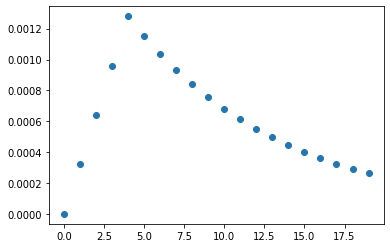

In [11]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * args.train_batch_size
    lr_min     = 0.000001
    lr_ramp_ep = args.lr_ramp_ep
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if args.resume:
            epoch = epoch + args.resume_epoch
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(args.epochs))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

# Get dataset

gs://kds-1a6a4ccf0eb63bdf264eecdeac8ba2c6391a8616af8c147a01a0a726/
10 10 51033 27956
51033


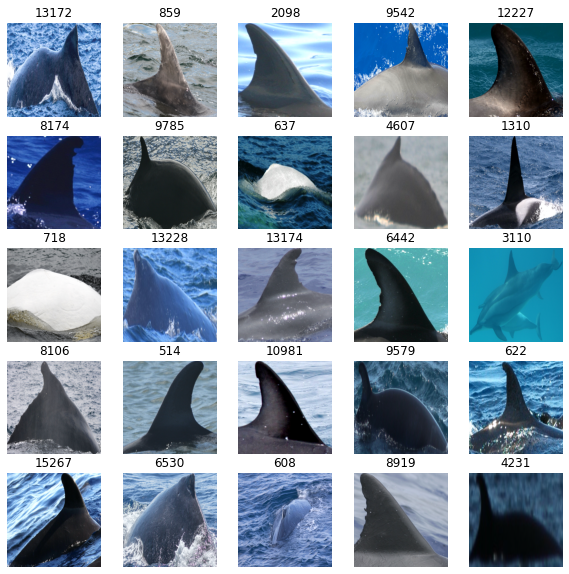

(256, 512, 512, 3)
27956


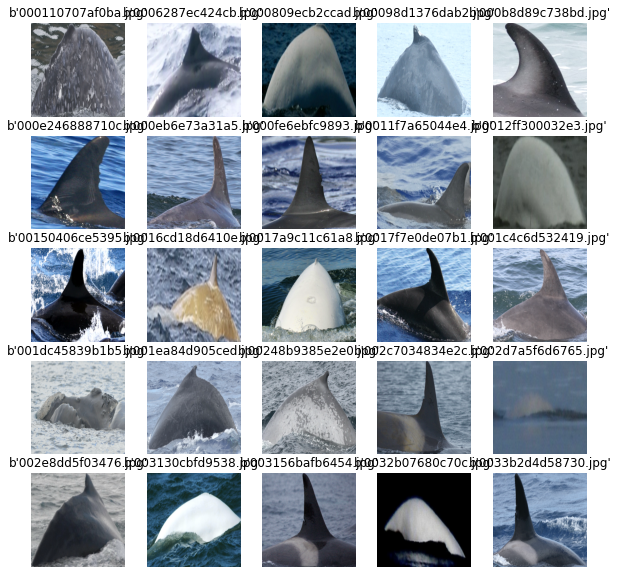

(512, 512, 512, 3)


In [12]:
seed_everything(args.seed)

if tpu is not None:
    train_files = np.sort(np.array(tf.io.gfile.glob(args.data_folderpath + 'happywhale-2022-train*.tfrec')))
    test_files = np.sort(np.array(tf.io.gfile.glob(args.data_folderpath + 'happywhale-2022-test*.tfrec')))
else:
    train_files = glob.glob(args.data_folderpath + 'happywhale-2022-train*.tfrec')
    test_files = glob.glob(args.data_folderpath + 'happywhale-2022-test*.tfrec')

print(args.data_folderpath)
print(len(train_files), len(test_files), count_data_items(train_files), count_data_items(test_files))

n_row=5; n_col=5
n_row = min(n_row, args.train_batch_size//n_col)
N_TRAIN = count_data_items(train_files)
print(N_TRAIN)
ds = get_training_dataset(train_files)

for (sample,label) in ds:
    img = sample['inp1']
    plt.figure(figsize=(10, int(10*n_row/n_col)))
    for j in range(n_row*n_col):
        plt.subplot(n_row,n_col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,]/225.0)
    plt.show()
    break
print(img.shape)

n_row = 5; col = 5;
n_row = min(n_row,args.train_batch_size//n_col)
N_TEST = count_data_items(test_files)
print(N_TEST)
ds = get_test_dataset(test_files)

for (img,label) in ds:
    plt.figure(figsize=(10,int(10*n_row/n_col)))
    for j in range(n_row*n_col):
        plt.subplot(n_row,n_col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,]/225.0)
    plt.show()
    break
print(img.shape)

# Training

In [13]:
for fold in range(args.n_folds):
    if fold+1 != args.run_fold:
        continue

    print('='*30, f'FOLD {fold+1}', '='*30)
    TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%args.n_folds!=fold]
    VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%args.n_folds==fold]
    
    print('TRAINING_FILENAMES:', len(TRAINING_FILENAMES), count_data_items(TRAINING_FILENAMES))
    print(TRAINING_FILENAMES)
    print('VALIDATION_FILENAMES:', len(VALIDATION_FILENAMES), count_data_items(VALIDATION_FILENAMES))
    print(VALIDATION_FILENAMES)


    train_dataset = get_training_dataset(TRAINING_FILENAMES)
    val_dataset = get_val_dataset(VALIDATION_FILENAMES)

    steps_per_epoch = count_data_items(TRAINING_FILENAMES) // args.train_batch_size
    
    # Model
    K.clear_session()
    with strategy.scope():
        model, embed_model = get_model(
            input_shape=args.image_size + (3,), 
            n_classes=args.n_classes, 
            backbone=args.backbone
        )

        opt = tf.keras.optimizers.Adam(learning_rate=args.lr)
        opt = tfa.optimizers.SWA(opt, start_averaging=int(steps_per_epoch*10), average_period=int(steps_per_epoch))
        model.compile(
            optimizer=opt,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)
            ]
        )
    model.summary()
    
    # Callbacks
    sv_loss = tf.keras.callbacks.ModelCheckpoint(
        args.save_folderpath+f"/{args.backbone}_loss_fold{args.run_fold}.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True,
        save_weights_only=True, 
        mode='min', 
        save_freq='epoch'
    )
    
    callbacks = [
        get_lr_callback(),
        sv_loss
    ]
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=args.epochs,
        callbacks=callbacks, 
        verbose=1
    )

model.load_weights(args.save_folderpath+f"/{args.backbone}_loss_fold{args.run_fold}.h5")

============================== FOLD 1 ==============================
TRAINING_FILENAMES: 8 40826
['gs://kds-1a6a4ccf0eb63bdf264eecdeac8ba2c6391a8616af8c147a01a0a726/happywhale-2022-train-1-5104.tfrec', 'gs://kds-1a6a4ccf0eb63bdf264eecdeac8ba2c6391a8616af8c147a01a0a726/happywhale-2022-train-2-5104.tfrec', 'gs://kds-1a6a4ccf0eb63bdf264eecdeac8ba2c6391a8616af8c147a01a0a726/happywhale-2022-train-3-5103.tfrec', 'gs://kds-1a6a4ccf0eb63bdf264eecdeac8ba2c6391a8616af8c147a01a0a726/happywhale-2022-train-4-5103.tfrec', 'gs://kds-1a6a4ccf0eb63bdf264eecdeac8ba2c6391a8616af8c147a01a0a726/happywhale-2022-train-6-5103.tfrec', 'gs://kds-1a6a4ccf0eb63bdf264eecdeac8ba2c6391a8616af8c147a01a0a726/happywhale-2022-train-7-5103.tfrec', 'gs://kds-1a6a4ccf0eb63bdf264eecdeac8ba2c6391a8616af8c147a01a0a726/happywhale-2022-train-8-5103.tfrec', 'gs://kds-1a6a4ccf0eb63bdf264eecdeac8ba2c6391a8616af8c147a01a0a726/happywhale-2022-train-9-5103.tfrec']
VALIDATION_FILENAMES: 2 10207
['gs://kds-1a6a4ccf0eb63bdf264eecdeac8ba

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 512, 512, 3)  0           ['inp1[0][0]']                   
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 512, 512, 3)  0           ['tf.cast[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 512, 512, 3)  0           ['tf.math.truediv[0][0]']    

Learning rate: [1e-06, 0.00032075, 0.0006405, 0.00096025, 0.00128, 0.0011521, 0.00103699, 0.000933391, 0.0008401519, 0.0007562367, 0.00068071304, 0.00061274174, 0.0005515676, 0.0004965108, 0.00044695972, 0.00040236374, 0.00036222738, 0.00032610464, 0.00029359417, 0.00026433475]


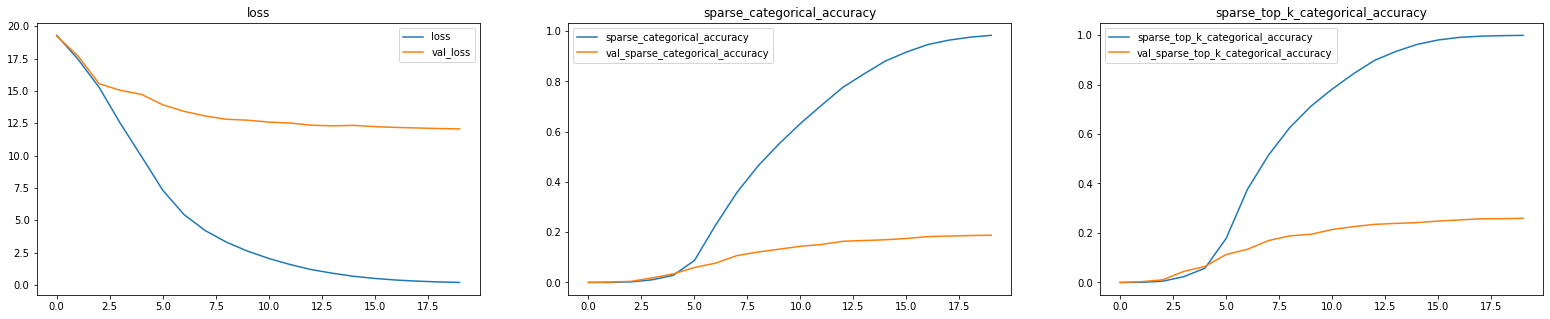

In [14]:
print('Learning rate:', history.history['lr'])

n_col, n_row = 3, 1
fig, axes = plt.subplots(n_row, n_col, figsize=(9*n_col, 5*n_row))
for idx, (ax, name) in enumerate(zip(axes, ['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy'])):
    ax.title.set_text(name)
    ax.plot(history.history[name], label=name)
    ax.plot(history.history['val_'+name], label='val_'+name)
    ax.legend()

# Evaluation

In [15]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds,verbose=0)
    return embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0
    
f = open ('./happywhale-splits/individual_ids.json', "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [16]:
train_targets = []
train_embeddings = []
for filename in tqdm(TRAINING_FILENAMES):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    train_embeddings.append(embeddings)
    train_targets.append(targets)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=args.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [18]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
for filename in tqdm(VALIDATION_FILENAMES):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, args.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets)

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

new_individual    2177
37c7aba965a5        79
114207cab555        40
e69d5f9f8d1e        33
ffbb4e585ff2        32
                  ... 
80f4e0d635a7         1
c3dad9e679f3         1
179af04b755d         1
b7065da154c5         1
5c0572fe9fc1         1
Name: target, Length: 3255, dtype: int64

In [20]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('val_neighbors.csv')
test_df.image.value_counts().value_counts()

  0%|          | 0/10207 [00:00<?, ?it/s]

1     420
20    182
17    171
21    171
18    169
     ... 
95      8
93      7
96      6
98      3
99      1
Name: image, Length: 99, dtype: int64

In [21]:
## Compute CV
best_th = 0
best_cv = 0
for th in [0.1*x for x in range(11)]:
    all_preds = get_predictions(test_df,threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target,preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv>best_cv:
        best_th = th
        best_cv = cv

0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.0: 0.5563110283792132


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.1: 0.5563110283792132


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.2: 0.5563110283792132


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.30000000000000004: 0.5563110283792132


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.4: 0.5570948042193229


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.5: 0.5961856242447946


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.6000000000000001: 0.6242056105287165


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.7000000000000001: 0.5890336697037934


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.8: 0.5415172593971418


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.9: 0.49013095587994915


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 1.0: 0.45221579961464203


In [22]:
print("Best threshold",best_th)
print("Best cv",best_cv)
val_targets_df.describe()

Best threshold 0.6000000000000001
Best cv 0.6242056105287165


,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0
count,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000,10207.000000
mean,0.556311,0.556311,0.556311,0.556311,0.557095,0.596186,0.624206,0.589034,0.541517,0.490131,0.452216
std,0.416746,0.416746,0.416746,0.416746,0.417110,0.433053,0.442008,0.430446,0.409545,0.379022,0.350018
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,0.500000,0.500000,0.500000,0.500000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] = val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

{False: 8030, True: 2177}
best_threshold 0.5


is_new_individual,False,True,adjusted_cv
0.0,0.571577,0.500000,0.564420
0.1,0.571577,0.500000,0.564420
0.2,0.571577,0.500000,0.564420
0.30000000000000004,0.571577,0.500000,0.564420
0.4,0.571515,0.503904,0.564754
0.5,0.567841,0.700735,0.581131
0.6000000000000001,0.537891,0.942582,0.578360
0.7000000000000001,0.479548,0.992880,0.530881
0.8,0.417406,0.999311,0.475596
0.9,0.351901,1.000000,0.416711


# Inference

In [24]:
train_embeddings = np.concatenate([train_embeddings,val_embeddings])
train_targets = np.concatenate([train_targets,val_targets])
print(train_embeddings.shape,train_targets.shape)

(51033, 512) (51033,)


In [25]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=args.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [26]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
for filename in tqdm(test_files):
    embeddings = get_embeddings(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, args.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
sample_submission = pd.read_csv('./sample_submission.csv',index_col='image')
print(len(test_ids),len(sample_submission))
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

27956 27956


  0%|          | 0/27956 [00:00<?, ?it/s]

26     457
30     447
27     446
33     445
32     441
      ... 
95      33
97      24
98      20
99      11
100      5
Name: image, Length: 100, dtype: int64

In [28]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [29]:
predictions = {}
for i,row in tqdm(test_df.iterrows()):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence>best_threshold_adjusted:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]
        
for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission.csv',index=False)
predictions.head()

0it [00:00, ?it/s]

  0%|          | 0/27956 [00:00<?, ?it/s]

,image,predictions
0,63c5c7038b9bd0.jpg,a6e325d8e924 new_individual 02947a94c3fc 938b7...
1,c0d1a1f9dd4a5b.jpg,a6e325d8e924 new_individual 02947a94c3fc 938b7...
2,93bb0e015a5353.jpg,114207cab555 new_individual 938b7e931166 5bf17...
3,b322a06ed1a866.jpg,a6e325d8e924 new_individual 02947a94c3fc 938b7...
4,1ad6da2c383b73.jpg,a6e325d8e924 new_individual 02947a94c3fc 938b7...
